**************************************
**Avatar : Genos**

**Matrícula : 190084731**
**************************************
**Avatar : Yoda**

**Matrícula : 180041991**
**************************************
**Link somente do dataset : https://drive.google.com/drive/folders/1bDTIkdgb3Wst4SY7SxDp-zgoOj4rZxTl?usp=sharing**
**Link do Modelo : https://drive.google.com/file/d/1_QRei4aBihC1mzWx9Y_xyDuBwsEaMBCe/view?usp=sharing**

In [ ]:
# Acesso ao drive
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Criação do dataset
from fastai.vision import download_images

# Design da nn
import torch
from torch import nn
from torch import optim

# Modulos para tratar do dataset
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms, models
import numpy as np

# Medir tempo de Execução
import time

# Ler imagens do usuário
from matplotlib import pyplot
from google.colab import files
from PIL import Image

# Embed plots do matplotlib no notebook
%matplotlib inline

In [ ]:
def testar_gpu():
	train_on_gpu = torch.cuda.is_available() #Observa se a GPU está disponivel
	if train_on_gpu: #Se sim
		device = torch.device('cuda') #Seleciona o device como GPU
		print("Treinando na GPU") #E manda a mensagem
	else: #Se não
		device = torch.device('cpu') #Seleciona o device como cpu
		print("GPU indisponível, treinando na CPU") #E avisa que a GPU não esta disponível
	return device

device = testar_gpu()

Treinando na GPU


In [ ]:
# NÃO RODAR
# Célula usada para criação do dataset, que foi curado manualmente em seguida
"""
animais = ['ariranha','capivara','jacare','loboguara','oncapintada','piranha','sucuri','tamanduabandeira','tatucanastra','tucano','pantanal']
path_padrao = '/content/drive/MyDrive/IMLDL Desafio Final/animais/'
dest_padrao = '/content/drive/MyDrive/IMLDL Desafio Final/animais_baixados/'
for seres in animais:
  path_download = path_padrao + seres + '.txt'
  dest_download = dest_padrao + seres
  download_images(path_download,dest_download, max_pics= 400)
"""

"\nanimais = ['ariranha','capivara','jacare','loboguara','oncapintada','piranha','sucuri','tamanduabandeira','tatucanastra','tucano','pantanal']\npath_padrao = '/content/drive/MyDrive/3° Semestre/IMLDL/Semana 8/Desafio Final IMLDL/animais/'\ndest_padrao = '/content/drive/MyDrive/3° Semestre/IMLDL/Semana 8/Desafio Final IMLDL/animais_baixados/'\nfor seres in animais:\n  path_download = path_padrao + seres + '.txt'\n  dest_download = dest_padrao + seres\n  download_images(path_download,dest_download, max_pics= 400)\n"

In [ ]:
# Definção das transformações que seram utilizadas no dataset para normalização e data augmentation.
# Transformações aleatórias só podem ocorrer na fase de treino.
# As transformações na fase de validação e teste devem ser consistentes.
data_transforms = {
    'train':transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.RandomRotation(10),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ]),
    'valid':transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ]),
}

In [ ]:
# Definição do PATH do dataset (alterar caso a pasta seja colocada em outro local)
dataset = ImageFolder('/content/drive/MyDrive/IMLDL Desafio Final/animais_baixados')
print('Total de imagens no dataset:', len(dataset))

Total de imagens no dataset: 2199


In [ ]:
# Essa classe possibilita a aplicação de diferentes transformações nos dados
# de acordo com a fase (treino, validação ou teste)
# Adaptado do seguinte post nos forúms do pytorch:
# https://discuss.pytorch.org/t/why-do-we-need-subsets-at-all/49391/7
class MyLazyDataset(torch.utils.data.Dataset): # fastai.Dataset
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

dataset_train = MyLazyDataset(dataset,data_transforms['train'])
dataset_valid = MyLazyDataset(dataset,data_transforms['valid'])
dataset_test  = MyLazyDataset(dataset,data_transforms['valid'])

In [ ]:
# Divisão entre os datasets de treino, teste e validação
porcentagem_treino = 80

# Calculando o número de exemplos para cada dataset
total = len(dataset)
n_treino = round(len(dataset)*(porcentagem_treino/100))
n_teste = round(len(dataset)* (100 - porcentagem_treino)/(2*100)) 
n_valid = len(dataset) - n_treino - n_teste

# Cria uma lista de indices aleatória que será usada para dividir os datasets
indices = list(range(total))
split = n_treino
split2 = n_treino+n_valid
np.random.shuffle(indices)
train_idx, valid_idx, test_idx = indices[:split], indices[split:split2], indices[split2:]

data_train = Subset(dataset_train, indices=train_idx)
data_valid = Subset(dataset_valid, indices=valid_idx)
data_test = Subset(dataset_test, indices=test_idx)

In [ ]:
print('nº de imagens para treino: {:}'.format(n_treino) +'; nº de imagens para teste: {:}'.format(n_teste) +'; nº de imagens para validação: {:}'.format(n_valid) + '.')

nº de imagens para treino: 1759; nº de imagens para teste: 220; nº de imagens para validação: 220.


In [ ]:
# Definicão do batch size e dos dataloaders
batch_size = 10

loader_train, loader_test, loader_valid = DataLoader(data_train, batch_size=batch_size, shuffle=True), DataLoader(data_test, batch_size=1), DataLoader(data_valid, batch_size=1)

In [ ]:
def importNN():
    """
    Importa uma rede neural pré-treinada e faz adaptações para se adequar a
    quantidade de classes (11) do problema.

    Retorna
    -------------
    model : torchvision.models.resnet.ResNet
        Variável que deve ser retornada com o modelo de rede pré-treinada 
        importado e adaptado ao problema.
    """
    model = 0
    classifier = 0 

    model = models.resnext101_32x8d(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
        
    classifier = nn.Sequential(nn.Linear(2048,512),
                              nn.ReLU(),
                              nn.Dropout(p=0.3), # era 0.2
                              nn.Linear(512,11))
    
    model.fc = classifier

    return model

In [ ]:
def define(model, lr):
    """
    Define o algoritmo de otimização dos parâmetros da rede e o critério de 
    seleção da saída que será tomada na previsão da classificação da entrada.

    Parâmetros
    -------------
	model : torchvision.models
        Variável que contém o modelo de rede pré-treinada importado e adaptado 
        ao problema.

    lr : float_like
        Learning rate que será tomado por base para a atualização dos 
        parâmetros.

    Retorna
    -------------
    optimizer : torch.optim
        Algoritmo de otimização que será responsável por atualizar os parâmetros
        da rede a partir de uma função de custo ('loss').
    criterion : torch.nn.modules
        Critério que definirá qual saída será escolhida como previsão na 
        classificação do exemplo de entrada.
    """
  
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.fc.parameters(),lr=lr)

    return optimizer, criterion

In [ ]:
def train_test(model, loader_train, loader_test):
    """
    Treina os parâmetros da(s) camada(s) "fully connected" da rede contida em 
    'model' com os exemplos contidos em 'data_train' (organizados por 
    'train_loader'). Em seguida, testa a acurácia e o erro de classificação da 
    rede com os exemplos contidos em 'data_test' (organizados por 
    'loader_test').

    Parâmetros
    -------------
    model : torchvision.models
        Variável que contém o modelo de rede pré-treinada importado e adaptado 
        ao problema.
    loader_train: torch.utils.data.dataloader.DataLoader
        Variável responsável por organizar e carregar os dados relacionados aos
        exemplos de treino ('data_train') conforme definimos anteriormente.
    loader_test: torch.utils.data.dataloader.DataLoader
        Variável responsável por organizar e carregar os dados relacionados aos
        exemplos de teste ('data_test') conforme definimos anteriormente.

	Retorna
    -------------
    train_loss : float_like
        Erro da rede na classificação dos exemplos de treino; será utilizado
        para fazer a atualização dos parâmetros da rede pelo otimizador.
    test_loss : float_like
        Erro da rede na classificação dos exemplos de teste; será utilizado
        para avaliar o desempenho da rede com parâmetros não utilizados no 
        treinamento, podendo indicar possíveis falhas.
    acc : float_like
        Acurácia de classificação dos exemplos de teste pela rede.
    """
    train_loss, test_loss, acc = 0,0,0
    
    # Fase de treino
    model.train().to(device)

    for img, lb in loader_train:

        img, lb = img.float().to(device), lb.to(device)
        out = model(img)
        loss = criterion(out, lb.float().long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss

    train_loss /= len(loader_train)

    # Fase de teste
    model.eval().to(device)
    n_prev = correct = 0

    with torch.no_grad():
        for v_img, v_lb in loader_test:

            v_img = v_img.float().to(device)
            v_lb = v_lb.to(device)
            v_out = model(v_img)

            test_loss += criterion(v_out, v_lb.float().long())
            _,prev = torch.max(v_out, dim = 1)
            n_prev += 1

            if prev == v_lb:
                correct += 1
        
        test_loss /= len(loader_test)
        acc = correct/n_prev*100

    return train_loss, test_loss, acc

In [ ]:
# Importando o modelo pré-treinado para a GPU
model = importNN().to(device)

In [ ]:
# Fase de treino/teste
START = time.time()

list_train_loss = []
list_test_loss = []
list_acc = []
time1epoch = 0
max_acc = 0
saved_loss = 9999

lr = 0.001 
epochs = 10 

optimizer, criterion = define(model, lr)

for epoch in range(1, epochs+1):
    start = time.time()
    train_loss, test_loss, acc = train_test(model, loader_train, loader_test)
    end = time.time()

    list_train_loss.append(train_loss), list_test_loss.append(test_loss), list_acc.append(acc)

    # Salvando o modelo com a melhor acurácia
    if acc >= max_acc and test_loss.item() < saved_loss:
        torch.save(model, "/content/drive/MyDrive/IMLDL Desafio Final/modeloNovo.pt")
        max_acc = acc
        saved_loss = test_loss.item()

    Time = end - start
    if epoch == 1:
        time1epoch = Time
    if epoch < 10:
        print('Epoch: ', epoch ,' test loss: {:.4f}'.format(test_loss.item()), ' Accuracy: {:.2f}'.format(acc), ' Time spent this epoch: {:.2f}'.format(Time), 'seconds.')
    else:
        print('Epoch:', epoch ,' test loss: {:.4f}'.format(test_loss.item()), ' Accuracy: {:.2f}'.format(acc), ' Time spent this epoch: {:.2f}'.format(Time), 'seconds.')
END = time.time()

print()
TIME = (END - START) - time1epoch
print('\n Time spent during training, excluding first epoch: {:.2f}'.format(TIME), 'seconds.')

print(f'Modelo salvo com a melhor acurácia: {max_acc} e test loss: {saved_loss} ')

Epoch:  1  test loss: 0.0661  Accuracy: 98.64  Time spent this epoch: 29.63 seconds.
Epoch:  2  test loss: 0.0787  Accuracy: 97.73  Time spent this epoch: 30.48 seconds.
Epoch:  3  test loss: 0.0370  Accuracy: 99.09  Time spent this epoch: 29.38 seconds.
Epoch:  4  test loss: 0.0498  Accuracy: 99.55  Time spent this epoch: 29.97 seconds.
Epoch:  5  test loss: 0.0322  Accuracy: 99.55  Time spent this epoch: 29.77 seconds.
Epoch:  6  test loss: 0.0609  Accuracy: 97.27  Time spent this epoch: 30.40 seconds.
Epoch:  7  test loss: 0.0437  Accuracy: 99.09  Time spent this epoch: 29.55 seconds.
Epoch:  8  test loss: 0.0483  Accuracy: 98.64  Time spent this epoch: 29.59 seconds.
Epoch:  9  test loss: 0.0327  Accuracy: 99.09  Time spent this epoch: 29.59 seconds.
Epoch: 10  test loss: 0.0452  Accuracy: 99.55  Time spent this epoch: 29.58 seconds.


 Time spent during training, excluding first epoch: 272.36 seconds.
Modelo salvo com a melhor acurácia: 99.54545454545455 e test loss: 0.03219666332

In [ ]:
# Imprimindo os resultados
fig, axs = pyplot.subplots(2, figsize=(15,8))
axs[0].plot(range(1, epochs+1), list_train_loss,label="Train loss") #Plota o erro de treino X epocas
axs[0].plot(range(1, epochs+1), list_test_loss, label="Test loss") #Plota o erro de teste x epocas
axs[0].set(xticks=range(1, epochs+1))
axs[0].set_title('Losses x Epochs') #Define o título
axs[0].set(xlabel='Epochs') #Define o nome do eixo x
axs[0].set(ylabel='Losses') #Define o nome do eixo y
axs[0].legend() #Mostra a legenda
axs[0].grid(True) #Mostra a grade


axs[1].plot(range(1, epochs+1), list_acc, label='Accuracy') #Plota a acuracia para erro de 1 graus x epocas
axs[1].set(xticks=range(1, epochs+1))
axs[1].set_title('Accuracy x epochs') #Define o título
axs[1].set(xlabel='Epochs') #Define o nome do eixo x
axs[1].set(ylabel='Accuracy (%)') #Define o nome do eixo y
axs[1].legend(loc='lower right') #Mostra a legenda
axs[1].grid(True) #Mostra a grade

pyplot.tight_layout()

In [ ]:
# Carregando o modelo salvo
model = torch.load('/content/drive/MyDrive/IMLDL Desafio Final/modelo.pt')

In [ ]:
# Fase de validação
total = 0
correct = 0
loss_valid = 0

for imagem_valid, label_valid in loader_valid:

	loss_v = 0

	imagem_valid, label_valid = imagem_valid.float().to(device), label_valid.to(device)
	outputs_valid = model(imagem_valid)
	_, previsao = torch.max(outputs_valid, dim = 1)
	loss_v = criterion (outputs_valid, label_valid.long())
	total = total + 1 #Adiciona +1 na variável que guarda o total de previsões feitas
	if previsao == label_valid: 
		correct = correct + 1 #Soma +1 na variável que mede quantas previsões dessa categoria (erro absoluto de 2 graus) estão certas
	loss_valid += loss_v

loss_valid = loss_valid/len(loader_valid)
accuracy = (correct/total)*100 #Calcula a acurácia para erro absoluto de 1 grau em porcentagem

print('A acurácia obtida foi de: {:.2f}'.format(accuracy) + '%.')
print()
print('O erro médio obtido foi de: {:.4f}'.format(loss_valid))
print()

A acurácia obtida foi de: 97.73%.

O erro médio obtido foi de: 0.0486



In [ ]:
def predict(img_tensor, model):
    """
    É utilizada para fazer uma previsão, a partir de uma imagem e um modelo,
    retornando a classe a qual a imagem pertence.
    
    Parâmetros
    -------------
    img_tensor : torch.Tensor
        Tensor de dimensões (1, 3, 224, 224) que representa uma imagem 224x224
        colorida (com 3 canais RGB)
    model : torchvision.models
        Variável que contém o modelo de rede treinada.

	Retorna
    -------------
    numero : string
        Valor de 0 a 10 representado as classes definidas em dicio
    letra : string
        Variavel que guarda uma letra, onde a = em extição, b = fora de extinção
        e c = não existe nenhuma das espécies listadas
    """
    animais = ['ariranha','capivara','jacare','loboguara','oncapintada','pantanal','piranha','sucuri','tamanduabandeira','tatucanastra','tucano']
    dicio = {'oncapintada': '0', 
             'loboguara': '1', 
             'ariranha': '2', 
             'tatucanastra': '3', 
             'tamanduabandeira': '4', 
             'jacare': '5', 
             'sucuri': '6', 
             'tucano': '7', 
             'piranha': '8', 
             'capivara': '9', 
             'pantanal': '10'}

    # Todas as utilizadas na rede foram normalizadas com esses valores
    normalizar = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img_tensor = normalizar(img_tensor)
    img_tensor.to(device)

    model.eval()
    outputs = model(img_tensor)
    _, previsao = torch.max(outputs, dim = 1)

    numero = dicio[animais[previsao]]
    if int(numero) <= int('4'):
        letra = 'a' # em extinção
    elif int(numero) <= int('9'):
        letra = 'b' # fora de extinção
    else:
        letra = 'c' # pantanal
    return numero, letra

In [ ]:
# Carregar uma imagem do computador
# Execute a célula novamente para enviar outra imagem
uploaded = files.upload()

Saving images.jpg to images.jpg


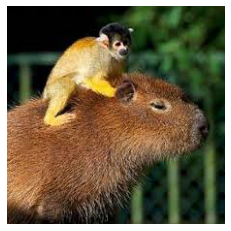

In [ ]:
# Carregando e imprimindo a imagem
name = ""
for key in uploaded.keys():
    name = key
img = Image.open(name)
pyplot.figure()
pyplot.axis('off')
pyplot.imshow(img)
pyplot.show()

In [ ]:
# Carregando o modelo salvo
model = torch.load('/content/drive/MyDrive/IMLDL Desafio Final/modelo.pt')

In [ ]:
transform = transforms.ToTensor() # A função predict só aceita tensores
img_tensor = transform(img).unsqueeze(0).to(device)
predict(img_tensor, model)

('9', 'b')